In [56]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

sys.path.insert(0, '../scripts/')
from variables import *


In [2]:
def load_data(input_frame):
    '''
    Input: initial data-frame 
    Return: another data-frame with some extra variables
    '''
    
    #copy the input_dataframe
    output_frame = input_frame.copy()

    #Add more variables computed using the initial variables
    for jet in ["j1", "j2"]:
        output_frame["pt" + jet] = np.sqrt(input_frame["px" + jet]**2 + input_frame["py" + jet]**2)
        output_frame["eta" + jet] = np.arcsinh(input_frame["pz" + jet] / output_frame["pt" + jet])
        output_frame["phi" + jet] = np.arctan2(input_frame["py" + jet], input_frame["px" + jet])
        output_frame["m" + jet] = input_frame["m" + jet]
        output_frame["p" + jet] = np.sqrt(input_frame["pz" + jet]**2 + output_frame["pt" + jet]**2)
        output_frame["e" + jet] = np.sqrt(output_frame["m" + jet]**2 + output_frame["p" + jet]**2)
        output_frame["tau21" + jet] = input_frame["tau2" + jet] / input_frame["tau1" + jet]
        output_frame["tau32" + jet] = input_frame["tau3" + jet] / input_frame["tau2" + jet]
    
    #Kinematic variables of the di-jet system
    output_frame["pxjj"] = output_frame["pxj1"] + output_frame["pxj2"]
    output_frame["pyjj"] = output_frame["pyj1"] + output_frame["pyj2"]
    output_frame["pzjj"] = output_frame["pzj1"] + output_frame["pzj2"]
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt(output_frame["pxjj"]**2 + output_frame["pyjj"]**2 + output_frame["pzjj"]**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    # NaN will appear while dividing by zero tau1 and tau1 variables. The NaNs are removed.
    output_frame.dropna(inplace = True)
    output_frame.reset_index(drop = True, inplace = True)

    
    return output_frame

In [3]:
raw_input = pd.read_hdf("../data/events_anomalydetection_v2.features.h5")

In [4]:
rawdata_shape = raw_input.shape
rawdata_features = list(raw_input.columns)
print("Shape of the raw dataframe: ", rawdata_shape)
print ("Features in the raw dataframe: ", rawdata_features)

Shape of the raw dataframe:  (1100000, 15)
Features in the raw dataframe:  ['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2', 'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'label']


In [5]:
# open the raw input file
df_sig_bkg = load_data(raw_input)

#signal and background events can be identified using the `label` feature
# Signal: label=1
# Backgrouns: label=0
df_bkg = df_sig_bkg.loc[df_sig_bkg['label'] == 0]
df_sig = df_sig_bkg.loc[df_sig_bkg['label'] == 1]

In [10]:
df_sig_bkg.keys()

Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'label', 'ptj1',
       'etaj1', 'phij1', 'pj1', 'ej1', 'tau21j1', 'tau32j1', 'ptj2', 'etaj2',
       'phij2', 'pj2', 'ej2', 'tau21j2', 'tau32j2', 'pxjj', 'pyjj', 'pzjj',
       'ejj', 'pjj', 'mjj'],
      dtype='object')

In [26]:
out_features = ["ptj1", "etaj1", "phij1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2", "mjj", "tau32j1", "tau32j2", "label"]

np_bkg = np.array(df_bkg[out_features])
np_sig = np.array(df_sig[out_features])
total_dataset = np.concatenate((np_bkg, np_sig))
total_dataset.shape

(1099847, 14)

In [29]:
np.random.seed(1)

indices = np.array(range(len(total_dataset))).astype('int')
np.random.shuffle(indices)
total_dataset = total_dataset[indices]

In [34]:
X = total_dataset[:,:-1]
y = total_dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
scaler = MinMaxScaler((-1,1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
def classifier_model():    
    model = tf.keras.Sequential()
#     adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.add(layers.Dense(64,input_dim = 13,activation ='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    # model.add(layers.Dropout(0.1))
    # model.add(layers.Dense(64,activation = 'relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [47]:
def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
#     plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")

In [48]:
def train_classifier():
    classifier = classifier_model()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-5, mode='min', verbose=1, patience=10)

#     best_model = tf.keras.callbacks.ModelCheckpoint('/home/elham/anomaly_detection/models/cGAN_4feb2022/cGAN_classifier.h5', verbose=1, save_best_only=True)
    best_model = tf.keras.callbacks.ModelCheckpoint('/home/elham/anomaly_detection/models/classifier_20sept2022/classifier.h5', verbose=1, save_best_only=True)
    history = classifier.fit(X_train, y_train, epochs=70, batch_size=512,validation_split = 0.2,callbacks=[best_model], verbose = 1)
    learningCurveLoss(history)

Train on 791889 samples, validate on 197973 samples
Epoch 1/70
790016/791889 [============================>.] - ETA: 0s - loss: 1.2162 - accuracy: 0.8839
Epoch 00001: val_loss improved from inf to 0.25142, saving model to /home/elham/anomaly_detection/models/classifier_20sept2022/classifier.h5
791889/791889 [==============================] - 12s 15us/sample - loss: 1.2139 - accuracy: 0.8840 - val_loss: 0.2514 - val_accuracy: 0.9205
Epoch 2/70
788480/791889 [============================>.] - ETA: 0s - loss: 0.4136 - accuracy: 0.9081
Epoch 00002: val_loss improved from 0.25142 to 0.20107, saving model to /home/elham/anomaly_detection/models/classifier_20sept2022/classifier.h5
791889/791889 [==============================] - 11s 14us/sample - loss: 0.4125 - accuracy: 0.9083 - val_loss: 0.2011 - val_accuracy: 0.9305
Epoch 3/70
787456/791889 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.9218
Epoch 00003: val_loss improved from 0.20107 to 0.16280, saving model to /h

787456/791889 [============================>.] - ETA: 0s - loss: 0.0969 - accuracy: 0.9667
Epoch 00025: val_loss improved from 0.09245 to 0.09139, saving model to /home/elham/anomaly_detection/models/classifier_20sept2022/classifier.h5
791889/791889 [==============================] - 10s 13us/sample - loss: 0.0969 - accuracy: 0.9667 - val_loss: 0.0914 - val_accuracy: 0.9686
Epoch 26/70
791552/791889 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9669
Epoch 00026: val_loss did not improve from 0.09139
791889/791889 [==============================] - 10s 12us/sample - loss: 0.0960 - accuracy: 0.9669 - val_loss: 0.0934 - val_accuracy: 0.9689
Epoch 27/70
791040/791889 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9671
Epoch 00027: val_loss did not improve from 0.09139
791889/791889 [==============================] - 10s 12us/sample - loss: 0.0961 - accuracy: 0.9670 - val_loss: 0.0942 - val_accuracy: 0.9671
Epoch 28/70
788480/791889 [======

Epoch 50/70
788992/791889 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9692
Epoch 00050: val_loss did not improve from 0.08227
791889/791889 [==============================] - 10s 13us/sample - loss: 0.0882 - accuracy: 0.9691 - val_loss: 0.0858 - val_accuracy: 0.9699
Epoch 51/70
789504/791889 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9693
Epoch 00051: val_loss did not improve from 0.08227
791889/791889 [==============================] - 10s 13us/sample - loss: 0.0878 - accuracy: 0.9693 - val_loss: 0.0918 - val_accuracy: 0.9692
Epoch 52/70
787968/791889 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9694
Epoch 00052: val_loss did not improve from 0.08227
791889/791889 [==============================] - 10s 13us/sample - loss: 0.0874 - accuracy: 0.9694 - val_loss: 0.0865 - val_accuracy: 0.9703
Epoch 53/70
790528/791889 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9694
Epoch 00053:

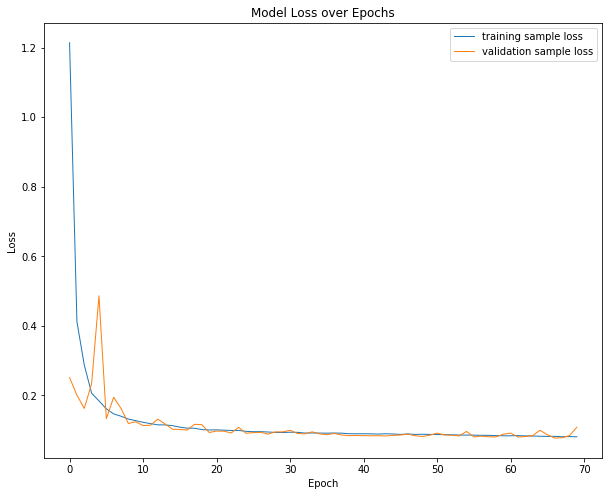

In [49]:
train_classifier()

In [51]:
trained_model = tf.keras.models.load_model('/home/elham/anomaly_detection/models/classifier_20sept2022/classifier.h5')

y_pred = trained_model.predict(X_test)
y_pred = y_pred.reshape(-1,)

pred_sig = []; pred_bkg = []
for i, true_label in enumerate(y_test):
    if true_label == 1:
        pred_sig.append(y_pred[i])
    else:
        pred_bkg.append(y_pred[i])

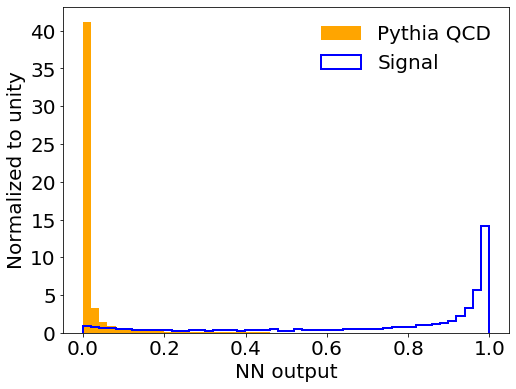

In [60]:
fig = plt.figure(figsize=(8, 6))
plt.hist(pred_bkg, bins=50, density = True, color='orange', label='Pythia QCD')
plt.hist(pred_sig, bins=50, histtype = "step", density = True, linewidth=2, color='b', label='Signal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(0, 10.0)

plt.xlabel('NN output', fontsize=20)
plt.ylabel('Normalized to unity', fontsize=20)
#plt.title('Background Rejection vs Signal Efficiency', fontsize=20)
plt.legend(frameon=False,fontsize=20)

0.9838176841998856
[0.9838176841998856]
[array([0.00000000e+00, 1.00070049e-04, 1.07074952e-02, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])]


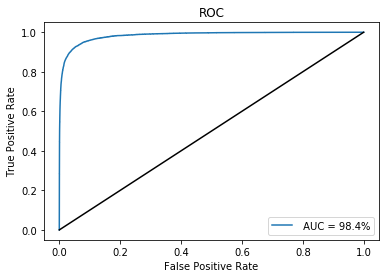

In [57]:
auc_list = []
tpr_list = []
fpr_list = []
y_pred = trained_model.predict(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_value = auc(fpr,tpr)
auc_list.append(auc_value)
fpr_list.append(fpr)
tpr_list.append(tpr)
plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
plt.plot([0, 1], [0, 1], 'k-')
print(auc_value)
print(auc_list)
print(tpr_list)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')